#  English sequence generator 

Goal: Create an English language sequence generator capable of building semi-coherent English sentences from scratch by building them up character-by-character.

Dataset:  Complete version of Sir Arthur Conan Doyle's classic book The Adventures of Sherlock Holmes

Based on [RNN project: text generation](https://github.com/udacity/aind2-rnn) of the [Udacity's Artificial Intelligence  Nanodegree](https://www.udacity.com/course/artificial-intelligence-nanodegree--nd889)

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import helper

## Load the data

In [2]:
text = open('data/holmes.txt').read().lower()
print('Total characters: {}'.format(len(text)))
text[:300]

Total characters: 581864


"\ufeffproject gutenberg's the adventures of sherlock holmes, by arthur conan doyle\n\nthis ebook is for the use of anyone anywhere at no cost and with\nalmost no restrictions whatsoever.  you may copy it, give it away or\nre-use it under the terms of the project gutenberg license included\nwith this ebook or "

## Preprocess the data

In [3]:
text = text[1302:]  # remove title, author page, and table of contents
text = text.replace('\n',' ') 
text = text.replace('\r',' ')

unique_characters = set(list(text))  
print(unique_characters)

{'x', 'e', 'h', '2', '?', 'q', ',', 'u', 'y', 'g', '.', 'l', '8', 'm', 'v', 'z', ' ', 'w', '1', '"', '3', ';', '5', 'à', 'a', 'é', 'k', '$', '-', '@', 'p', '4', 's', 'r', 'c', ':', 'i', 'f', 'è', 'n', '6', 'j', "'", '(', '%', 't', '7', 'â', 'd', 'b', '!', '/', '0', '9', ')', '*', 'o', '&'}


In [4]:
# remove non-english characters 
import re
text = re.sub("[$%&'()*@/àâèé0123456789-]", " ", text)
text = text.replace('"',' ')
text = text.replace('  ',' ') # shorten any extra dead space created above
text[:300]

'is eyes she eclipses and predominates the whole of her sex. it was not that he felt any emotion akin to love for irene adler. all emotions, and that one particularly, were abhorrent to his cold, precise but admirably balanced mind. he was, i take it, the most perfect reasoning and observing machine '

In [5]:
chars = sorted(list(set(text)))
num_chars = len(chars)
print('Total characters: {}'.format(len(text)))
print('Unique characters: {}'.format(num_chars))
print(chars)

Total characters: 573681
Unique characters: 33
[' ', '!', ',', '.', ':', ';', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


## Split data into input/output pairs

In [6]:
# Transforms the input text and window-size into a set of input/output pairs 
#  for use with the RNN """

window_size = 100
step_size = 5

input_pairs = []
output_pairs = []

for i in range(0, len(text) - window_size, step_size):
    input_pairs.append(text[i : i + window_size])   
    output_pairs.append(text[i + window_size])       

## One-hot encoding characters

In [7]:
chars_to_indices = dict((c, i) for i, c in enumerate(chars))
indices_to_chars = dict((i, c) for i, c in enumerate(chars))

# create variables for one-hot encoded input/output
X = np.zeros((len(input_pairs), window_size, num_chars), dtype=np.bool)
y = np.zeros((len(input_pairs), num_chars), dtype=np.bool)

# transform character-based input_pairs/output_pairs into equivalent numerical versions
for i, sentence in enumerate(input_pairs):
    for t, char in enumerate(sentence):
        X[i, t, chars_to_indices[char]] = 1
    y[i, chars_to_indices[output_pairs[i]]] = 1

## Recurrent Neural Network Model

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
import keras
import random

model = Sequential()  
model.add(LSTM(200, input_shape = (window_size, num_chars)))  
model.add(Dense(num_chars, activation=None))   
model.add(Dense(num_chars, activation="softmax")) 

# initialize optimizer
optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

model.compile(loss='categorical_crossentropy', optimizer=optimizer)

Using TensorFlow backend.


In [9]:
# a small subset of our input/output pairs
Xsmall = X[:10000,:,:]
ysmall = y[:10000,:]

Training loss: 1.7306


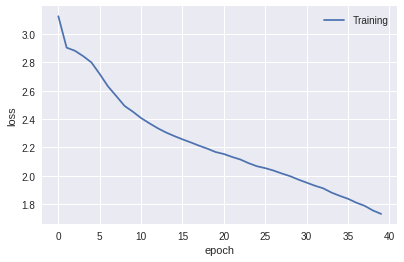

In [10]:
# train the model
history = model.fit(Xsmall, ysmall, batch_size=500, epochs=40,verbose = 0)
# model.save_weights('models/text_generation_weights.hdf5')


helper.show_training(history)

## Predict

In [22]:
def predict_next_chars(model,input_chars,num_to_predict):     
    """ predict a number of future characters """

    predicted_chars = ''
    for i in range(num_to_predict):
        x_test = np.zeros((1, window_size, len(chars)))
        for t, char in enumerate(input_chars):
            x_test[0, t, chars_to_indices[char]] = 1.

        test_predict = model.predict(x_test,verbose = 0)[0]

        # translate numerical prediction back to characters
        r = np.argmax(test_predict)
        d = indices_to_chars[r] 

        # update predicted_chars and input
        predicted_chars += d
        input_chars += d
        input_chars = input_chars[1:]
    return predicted_chars


for s in range(0,500,100):
    start_index = s
    input_chars = text[start_index: start_index + window_size]
    predict_input = predict_next_chars(model,input_chars,num_to_predict = 100)

    print('------------------')
    input_line = 'input chars = ' + '\n' +  input_chars + '"' + '\n'
    print(input_line)

    line = 'predicted chars = ' + '\n' +  predict_input + '"' + '\n'
    print(line)

------------------
input chars = 
is eyes she eclipses and predominates the whole of her sex. it was not that he felt any emotion akin"

predicted chars = 
 the long the mast the wing had the mare the coucurad the mas and the roughad the was and the bred h"

------------------
input chars = 
 to love for irene adler. all emotions, and that one particularly, were abhorrent to his cold, preci"

predicted chars = 
st in whe dond whe his was the mand he round ho whe sis and ther ing had me to the wing he was the c"

------------------
input chars = 
se but admirably balanced mind. he was, i take it, the most perfect reasoning and observing machine "

predicted chars = 
to mas in the core the mast fre she had the wald the has the coure the was in the dount he was the c"

------------------
input chars = 
that the world has seen, but as a lover he would have placed himself in a false position. he never s"

predicted chars = 
our the and the sourd ho whe hing we the sere the core to mas the c